In [1]:
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# from importlib import reload
# import feature_extraction
# reload(feature_extraction)
from biomarkers import (
    EEG,
    EMG,
    BP,
    EOG,
    ECG,
    TREV,
    GSR,
    Resp,
    EGG,
    MARKER_TO_CHANNEL_NAMES,
)
from feature_extraction import (
    Feature,
    EEG_BANDS,
    STAT_FEATURES,
)
from data_utils import (
    extract_features,
    extract_labels,
    load_data_from_dir,
    get_all_behaviors_labels,
    get_all_features_by_marker,
    extract_features_by_channel,
)
from calculate_correlation import (
    EEG_BANDS_LIST,
    get_all_behaviors_feature_to_pc_by_markers,
    get_all_trials_average_rp_values,
)

In [ ]:
"""
    load features from csv
"""
from dataframe.csv_utils import (
    load_data_from_csv,
    get_labels_from_result,
    get_features_from_result,
)

dir_name = "extracted_features_v1"
result = load_data_from_csv(dir_name)
all_label_array, label_list = get_labels_from_result(result)
all_feature_array, feature_names = get_features_from_result(result)
all_feature_array = all_feature_array.drop(["index"], axis=1)
feature_names = all_feature_array.columns
print(all_feature_array.shape, len(feature_names), len(label_list))

In [7]:
ALL_DIRS = [
    "../CleandDataV1/2045",
#     "../CleandDataV1/2018",
#     "../CleandDataV1/2020",
#     "../CleandDataV1/2024",
#     "../CleandDataV1/2025",
]

dir_to_data = {}
for dir_name in ALL_DIRS:
    all_data = load_data_from_dir(dir_name)
    dir_to_data[dir_name] = all_data

Loading ../CleandDataV1/2045 data...


In [ ]:
from dataframe.extraction import (
    extract_features_by_markers,
)

"""
  extract features from physiological signals
"""
# (TODO) GSR, Resp, TREV  BP.__name__, EGG.__name__
markers = [EEG.__name__]
for s in ALL_DIRS:
    # extract features
    df = extract_features_by_markers(markers, dir_to_data, [s])
#     print(s, df.shape)
#     subject_features = result[result["Subject"] == s]
#     subject_features = subject_features.reset_index()

    all_features = df #pd.concat([df, subject_features], axis=1)
    # save features to csv
    subject_name = s.replace("../CleandDataV1/", "")
    """ 
      extract labels from behavior data
    """
    all_label_array = extract_labels(dir_to_data, all_dir=[s])
    all_features["Valence"] = all_label_array["valence"]
    all_features["Arousal"] = all_label_array["arousal"]
    all_features["Attention"] = all_label_array["attention"]
    all_features["Subject"] = [s]*130
    all_features.to_csv(
        f"eeg_features/{subject_name}_features.csv", index=False
    )        

Extracting PSD features for 0...
Extracting PSD features for 1...
Extracting PSD features for 2...
Extracting PSD features for 3...
Extracting PSD features for 4...
Extracting PSD features for 5...
Extracting PSD features for 6...
Extracting PSD features for 7...
Extracting PSD features for 8...
Extracting PSD features for 9...
Extracting PSD features for 10...


In [4]:
all_features.head()

,A1 _DELTA,A1 _THETA,A1 _ALPHA,A1 _BETA1,A1 _BETA2,A1 _GAMMA,A2_DELTA,A2_THETA,A2_ALPHA,A2_BETA1,...,D31_ALPHA,D31_BETA1,D31_BETA2,D31_GAMMA,D32_DELTA,D32_THETA,D32_ALPHA,D32_BETA1,D32_BETA2,D32_GAMMA
0,73.450818,11.974813,7.707236,5.906258,0.0,1.923646,48.328432,6.082945,3.635339,2.735234,...,18.414223,14.701647,0.0,3.704676,79.944533,29.424212,27.747275,21.720125,0.0,5.061607
1,20.774830,8.109467,5.559378,4.529670,0.0,1.808268,7.573408,3.522133,2.404942,2.050596,...,16.519905,13.915669,0.0,3.314991,32.838572,21.230224,24.367649,20.139531,0.0,4.608276
2,19.944148,8.217440,5.939081,4.862319,0.0,1.867156,9.309150,3.681889,2.587329,2.200381,...,15.090955,12.119226,0.0,3.862289,44.042193,22.829618,21.925969,17.512859,0.0,4.818560
3,30.552907,9.563928,5.546113,4.958565,0.0,1.917983,10.057606,3.832767,2.229552,2.198014,...,21.515254,15.838460,0.0,3.268998,38.048059,27.922288,29.940454,22.124942,0.0,4.543175
4,42.009537,9.909435,7.353847,6.157661,0.0,2.132204,33.323257,4.612112,3.309321,2.992458,...,29.546456,22.768920,0.0,4.235031,66.622335,38.584449,45.571213,34.068369,0.0,5.904881


In [ ]:
"""
    calculate correlation
"""
from dataframe.correlation import (
    get_feature_to_corr_by_behavior,
    get_behavior_to_average_corr,
)

marker = EEG.__name__
behavior_to_rp = {}
for b in ["Valence", "Arousal", "Attention"]:
    behavior_to_rp[b] = get_feature_to_corr_by_behavior(
        result, b, feature_names, marker, "pearsonr"
    )

avg_condition_to_features = get_behavior_to_average_corr(behavior_to_rp)

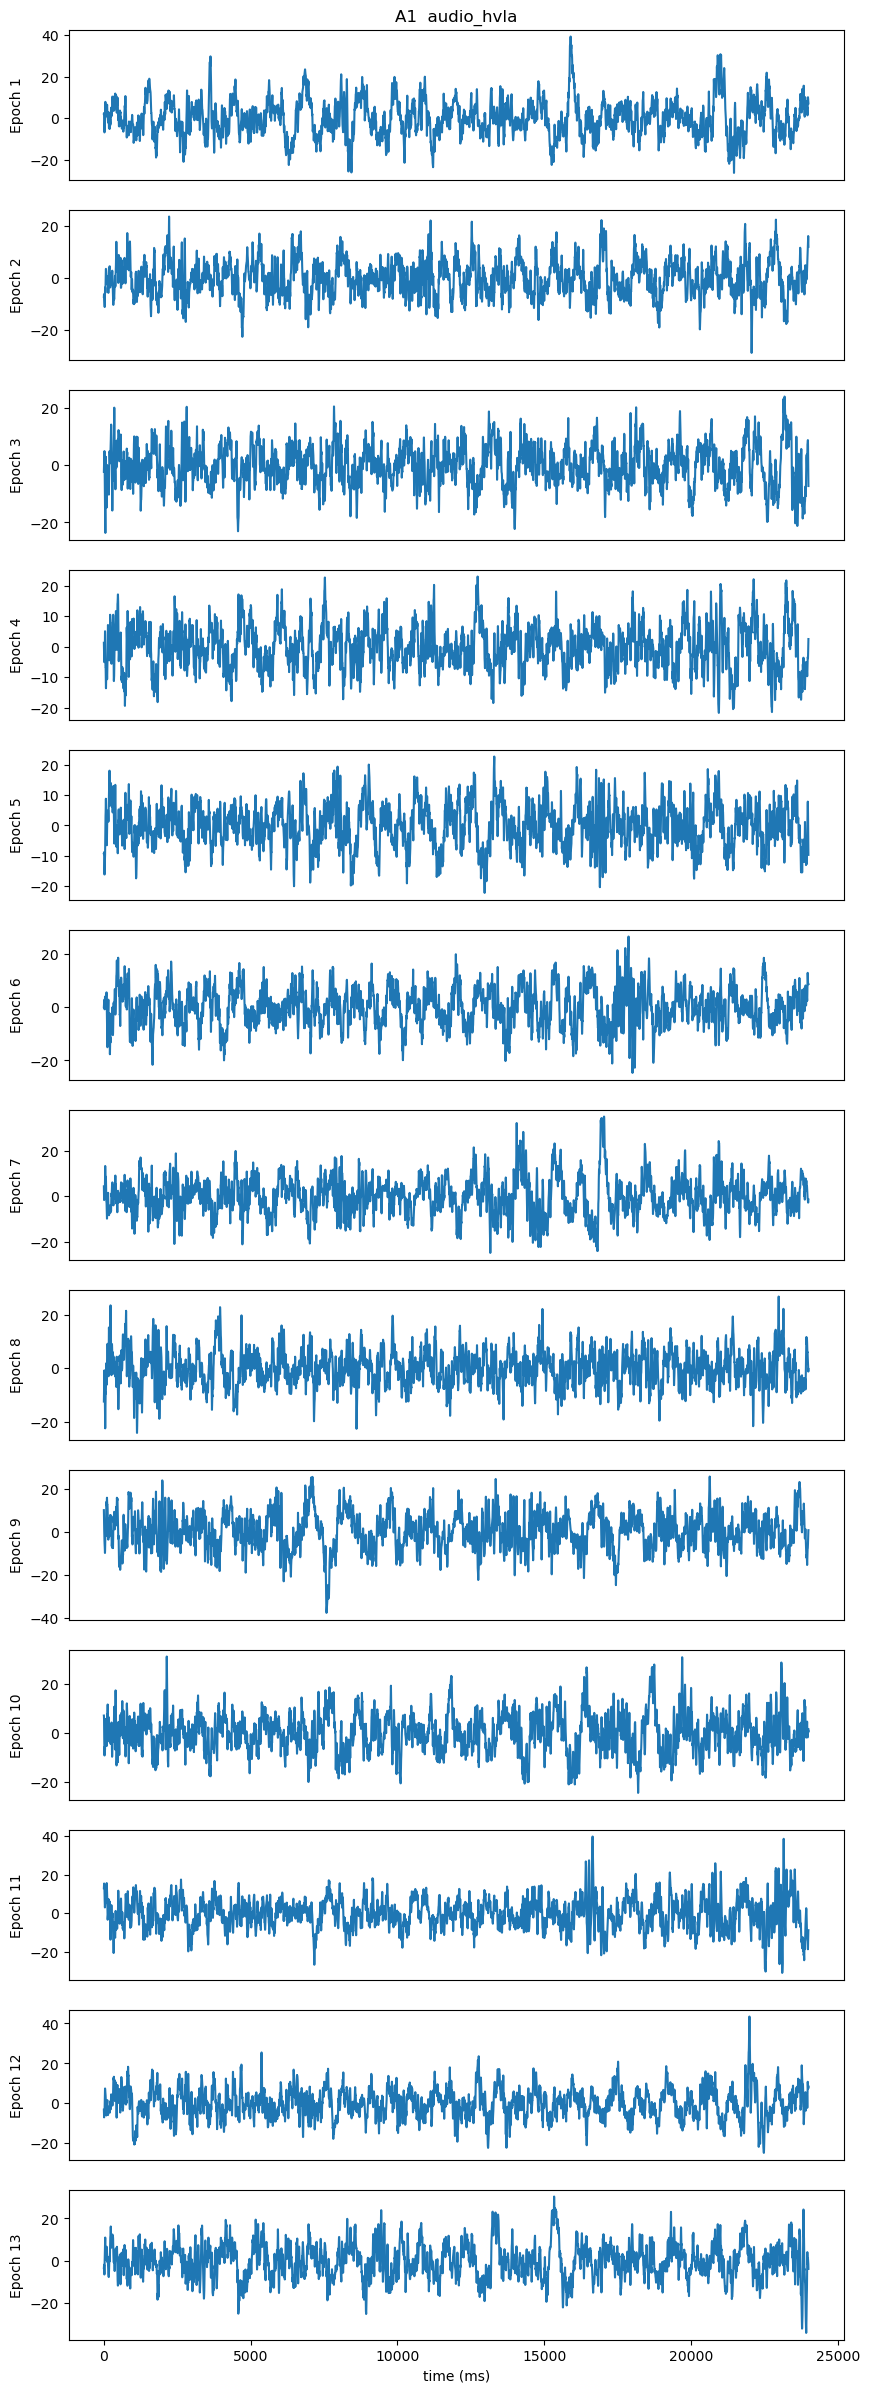

' \n    plot the scattor for physiological signals\n'

In [12]:
from plotting import (
    plot_correlation_table_by_channel,
    plot_k_chaneels_by_r_value,
    plot_eeg_topomap_all_blocks,
    plot_time_series_by_epoch,
)

""" plot the single channel correlation table
"""
# channel = 1
# features = STAT_FEATURES
# channel_names = MARKER_TO_CHANNEL_NAMES[marker]
# for condition, feature_to_pc in avg_condition_to_features.items():
#     label = f"{channel_names[channel]} {condition}"
#     plot_correlation_table_by_channel(
#         label,
#         feature_to_pc,
#         ["pearson r", "pearson p", "spearman r", "spearman p"],
#         features,
#         channel,
#         True,
#     )

""" plot the top channel correlation table given r values
"""
# for condition, feature_to_pc in avg_condition_to_features.items():
#     features = feature_to_pc.keys()
#     plot_k_chaneels_by_r_value(feature_to_pc, channel_names, features, condition, True, 10)
#     plot_k_chaneels_by_r_value(feature_to_pc, channel_names, features, condition, False, 10)

""" 
    plot the topography for eeg
"""
# for condition, feature_to_pc in avg_condition_to_features.items():
#     plot_eeg_topomap_all_blocks(condition, feature_to_pc)
#     features = feature_to_pc.keys()
#     for f in features:
#         plot_eeg_topomap_one_block(condition, f, feature_to_pc, all_block_names)


""" plot the top channel correlation table with different blocks
"""
# all_block_names = list(all_data.keys())
# all_block_names.sort()
# for condition, feature_to_pc in avg_condition_to_features.items():
#     plot_eeg_pearson_correlation_table(condition, feature_to_pc, all_block_names, 1)

""" plot the series for the top k channels
"""
# define number of rows and columns for subplots
# nrow = 3
# ncol = 2
# for condition, feature_to_pc in avg_condition_to_features.items():
#     print(f"{condition}")
#     ser_list = get_eeg_pearson_correlation_series_all_blocks(feature_to_pc, channel_names, k=20)
#     plot_series(nrow, ncol, ser_list)


""" 
    plot the time series given the marker and block
"""
# plot_time_series_by_epoch(all_data['audio_hvla'], 'EEG', 'audio_hvla', 0)

""" 
    plot the scattor for physiological signals
"""
# plot_pd_scatter_by_marker("LEOG", result, ['../2007', '../2002', '../2006'])

In [ ]:
""" 
    discard high correlated features
"""
corr = all_feature_array.corr()
updated = corr[(((corr < 0.9) & (corr > -0.9)) | (corr == 1)).all(axis=1)]
all_feature_array = all_feature_array[list(updated.index.values)]
feature_names = all_feature_array.columns

print(all_feature_array.shape, len(feature_names), len(label_list))

In [ ]:
import seaborn as sns

"""
    plot the correlation heatmap
"""
corr = all_feature_array.corr()
sorted_corr = corr.sort_index().sort_index(axis=1)
truncated_corr = sorted_corr.truncate(
    before="D7_ALPHA", after="VEOG_VAR", axis="rows"
).truncate(before="D7_ALPHA", after="VEOG_VAR", axis="columns")

plt.figure(figsize=(14, 12))
sns.heatmap(truncated_corr, vmin=-1, vmax=1, annot=False, cmap="RdBu_r")

In [ ]:
features = STAT_FEATURES
marker = EOG.__name__

channel_names = dir_to_data["../2002"]["audio_hvla"].get_chanlocs(marker)
channel_num = 0
""" 
    extract features from physiological signals
"""
# features_to_trials = extract_features_by_channel(marker, dir_to_data, features, channel_num, channel_names[channel_num])
# dir_name_to_labels = {}
# for dir_name, all_data in dir_to_data.items():
#     dir_name_to_labels[dir_name] = get_all_behaviors_labels(all_data)

In [ ]:
""" 
    extract correlation from physiological signals
"""
num_channels = 4
num_blocks = 0
dir_name_to_ctf = {}
for dir_name, all_data in dir_to_data.items():
    dir_name_to_ctf[dir_name] = get_all_behaviors_feature_to_pc_by_markers(
        all_data, marker, features, num_channels, num_blocks
    )

avg_condition_to_features = get_all_trials_average_rp_values(
    dir_name_to_ctf, features, "pearson"
)
spearman_corr = get_all_trials_average_rp_values(dir_name_to_ctf, features, "spearman")
for b, feature_to_pc in avg_condition_to_features.items():
    for f, pc in feature_to_pc.items():
        avg_condition_to_features[b][f] = np.hstack((pc, spearman_corr[b][f]))
